In [1]:
import psycopg2
import numpy as np
from psycopg2.extras import DictCursor
import matplotlib.pyplot as plt

try:
        print("\033[95mconnection to database...")
        conn = psycopg2.connect(
            database='piscineds',
            user='bgales',
            password='mysecretpassword',
            host='localhost'
        )
        cursor = conn.cursor(cursor_factory=DictCursor)
        print('\033[92mconnection with database OK')

        cursor.execute('BEGIN;')
except Exception as e:
    print("\033[91mError: ", e)
    print('\033[93mrollback in progress...\033[0m')
    conn.rollback()

connection to database...
connection with database OK


In [2]:
def hide_ticks_frame():
    plt.tick_params(axis='both', which='both', length=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().set_facecolor('#EAEAF2')

def display_info(result: dict, sells_arr):
    result['mean'] = np.mean(sells_arr)
    result['std'] = np.std(sells_arr)
    result['min'] = np.min(sells_arr)
    result['quarter'] = np.percentile(sells_arr, 25)
    result['mean'] = np.percentile(sells_arr, 50)
    result['three_quarter'] = np.percentile(sells_arr, 75)
    result['max'] = np.max(sells_arr)
    print(f'count {result["profit"]}')
    print(f"mean {result['mean']}")
    print(f"std {result['std']}")
    print(f"min {result['min']}")
    print(f"25% {result['quarter']}")
    print(f"50% {result['mean']}")
    print(f"75% {result['three_quarter']}")
    print(f"max {result['max']}")

In [3]:
try:
    print('\033[93mfetching data from database \
for the two first graph...\033[0m')
    cursor.execute(
        '''
            SELECT
                (SElECT SUM(price) FROM customers
                    WHERE event_type = 'purchase') AS profit,
                (SELECT COUNT(event_type)
                    FROM customers WHERE event_type = 'purchase')
                        AS nbr_of_purchase
        '''
    )
    result = cursor.fetchone()
    result = dict(result)

    cursor.execute(
        '''
            SELECT price
            FROM customers
            WHERE event_type = 'purchase'
        '''
    )
    print('\033[92mdata fetched with success!\033[0m')
    sells_arr = np.array(cursor.fetchall())

    display_info(result, sells_arr)
except Exception as e:
        print("\033[91mError: ", e)
        print('\033[93mrollback in progress...\033[0m')
        conn.rollback()

fetching data from database for the two first graph...
data fetched with success!
count 6344462.140000869
mean 3.0
std 8.927050009728575
min -79.37
25% 1.59
50% 3.0
75% 5.4
max 327.78


displaying graph one...


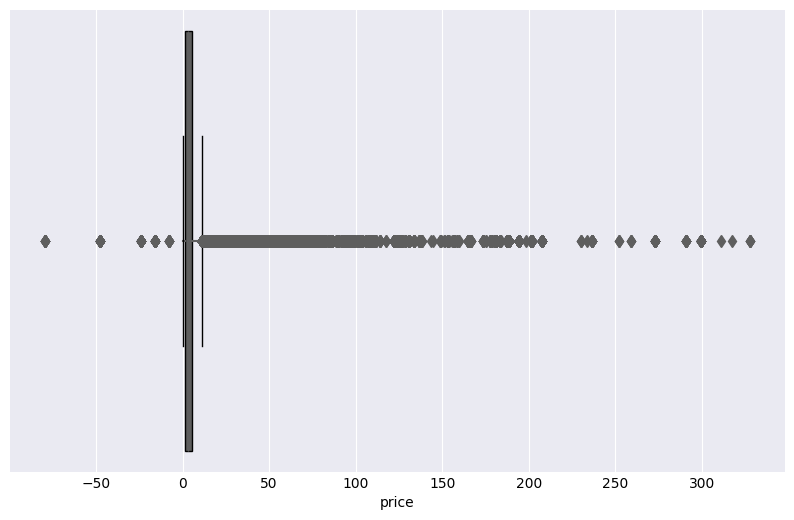

In [4]:
print('\033[2mdisplaying graph one...\033[0m')
plt.figure(figsize=(10, 6))
hide_ticks_frame()
gray = '#5E5E5E'
bplot = plt.boxplot(sells_arr, vert=False,
                    medianprops={'color': gray},
                    whiskerprops={'color': gray, 'linewidth': '1.5'},
                    flierprops={'marker': 'd', 'markerfacecolor': gray,
                                'markeredgecolor': gray},
                    widths=2.0, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor(gray)
plt.xlabel("price")
plt.yticks([])
plt.grid(axis='x', color='white', linestyle='-')
plt.show()

displaying zoomed graph one...


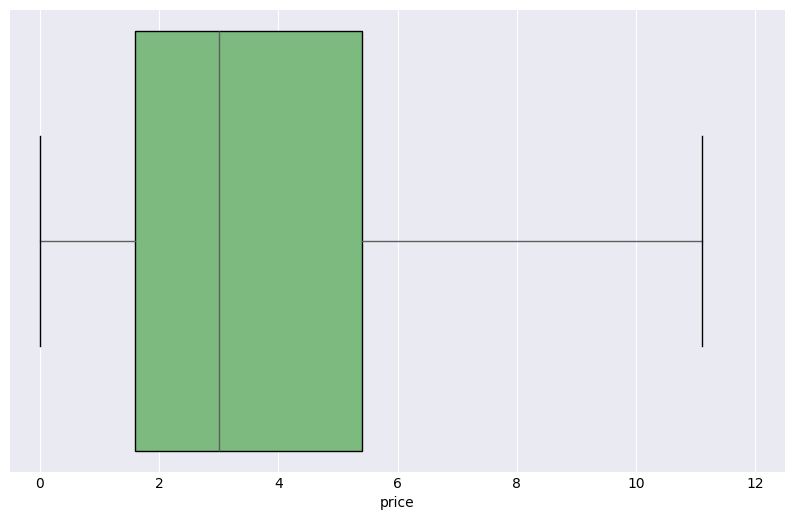

In [5]:
print('\033[2mdisplaying zoomed graph one...\033[0m')
plt.figure(figsize=(10, 6))
hide_ticks_frame()
gray = '#5E5E5E'
bplot = plt.boxplot(sells_arr, vert=False,
                    medianprops={'color': gray},
                    whiskerprops={'color': gray},
                    flierprops={'marker': 'd', 'markerfacecolor': gray,
                                'markeredgecolor': gray},
                    widths=2.0, showfliers=False, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor('#7DBA7F')
plt.xlabel("price")
plt.xlim(-0.5, 12.5)
plt.yticks([])
plt.grid(axis='x', color='white', linestyle='-')
plt.show()

In [6]:
try:
    print('\033[93mfetching data from database for the third graph...\033[0m')
    cursor.execute(
        '''
           SELECT AVG(total_price) AS average_price
            FROM (
                SELECT user_id,  SUM(CASE WHEN event_type = 'cart' THEN price
                    WHEN event_type = 'remove_from_cart' THEN -price
                    END) AS total_price
                FROM customers
                GROUP BY user_id
            ) AS _
            WHERE total_price > 0
            GROUP BY user_id
            HAVING AVG(total_price) BETWEEN 0 AND 100

        '''
    )
    print('\033[92mdata fetched with success!\033[0m')
    average_basket = np.array(cursor.fetchall())
except Exception as e:
        print("\033[91mError: ", e)
        print('\033[93mrollback in progress...\033[0m')
        conn.rollback()

fetching data from database for the third graph...
data fetched with success!


displaying graph two...


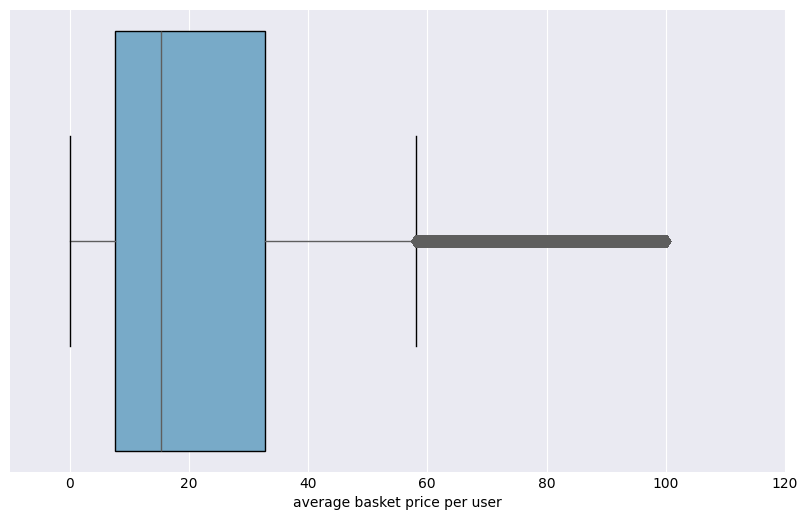

closing connection with database...


In [7]:
print('\033[2mdisplaying graph two...\033[0m')
plt.figure(figsize=(10, 6))
hide_ticks_frame()
gray = '#5E5E5E'
bplot = plt.boxplot(
    average_basket, vert=False,
    medianprops={'color': gray},
    whiskerprops={'color': gray},
    widths=1.5, whis=1,
    patch_artist=True,
    flierprops={'marker': 'd', 'markerfacecolor': gray,
                'markeredgecolor': gray})
for patch in bplot['boxes']:
    patch.set_facecolor('#78AAC8')
plt.xlabel("average basket price per user")
plt.yticks([])
plt.xlim(-10, 120)
plt.grid(axis='x', color='white', linestyle='-')
plt.show()

if conn:
    print("\033[95mclosing connection with database...")
    cursor.close()
    conn.close()